# VarClump2D: Concept test

## _Without optimizations..._

In [1]:
%matplotlib inline

import os
import sys
import copy
from array import array
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *

# ACALIB helper functions
sys.path.append('../../ACALIB/')
import acalib
from acalib import load_fits, standarize

# extra metric module
#import custom_metric as cm

## Loading data 2D: Stacked on frequency

In [2]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

# stacking it
data = data.sum(axis=0)
data -= data.min()
data /= data.max()

# generating the data function
x = np.linspace(0., 1., len(data[0]), endpoint=True)
y = np.linspace(0., 1., len(data[1]), endpoint=True)
dfunc = sp.interpolate.interp2d(x, y, data, kind='linear')

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


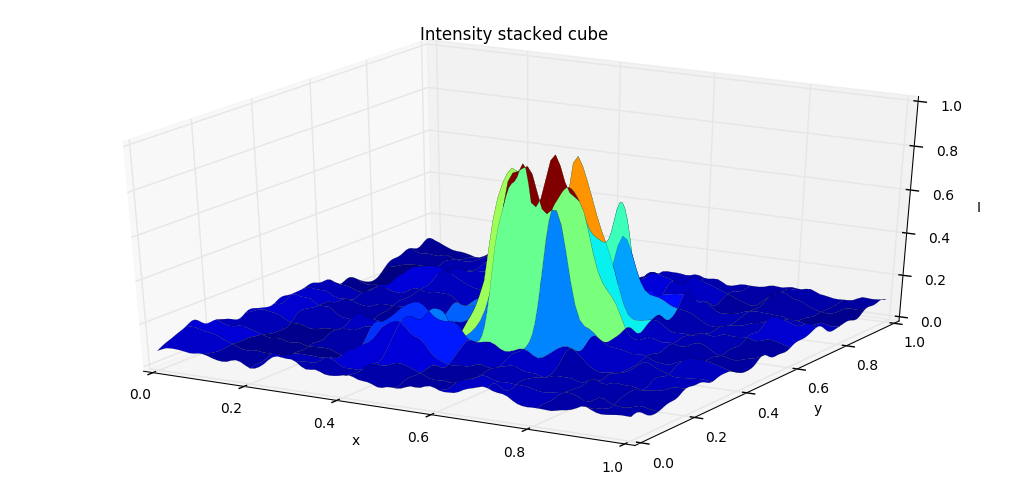

In [3]:
X,Y = np.meshgrid(x,y,sparse=True)
#3d plot
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, data, linewidth=0.1, cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('I')
plt.title('Intensity stacked cube')
plt.show()

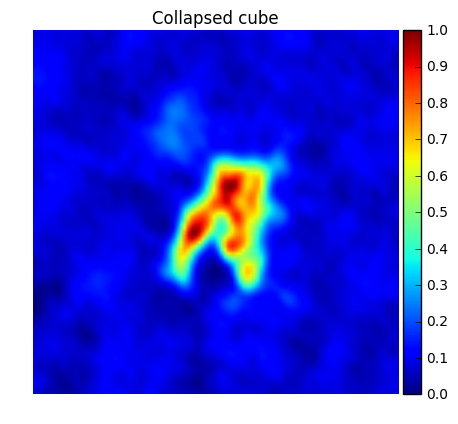

In [4]:
plt.figure(figsize=(5,5))
im = plt.imshow(data)
plt.title('Collapsed cube')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^2} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^2}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i,y_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

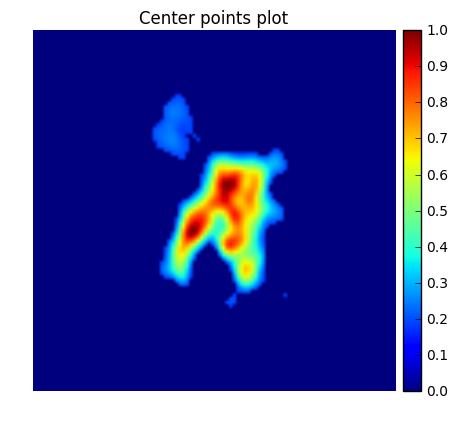

In [5]:
plt.figure(figsize=(5,5))
ax = plt.gca()
_data = np.zeros(data.shape)
mask = data > estimate_rms(data)
_data[mask] = data[mask]
im = ax.imshow(_data)
plt.title('Center points plot')
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.08)
plt.colorbar(im, cax=cax)
plt.show()

In [6]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 0
Nc = 500
Ne = 2*Nc-4*Nb

boundary_points = boundary_generation(Nb)

In [7]:
cut_value = acalib.rms(data)/2

In [8]:
center_points = random_centers_generation(data, Nc, cut_value_leq=cut_value)
extra_points = random_centers_generation(data, Ne, cut_value_geq=cut_value)
collocation_points = np.vstack((center_points, extra_points))

### Visualization of points

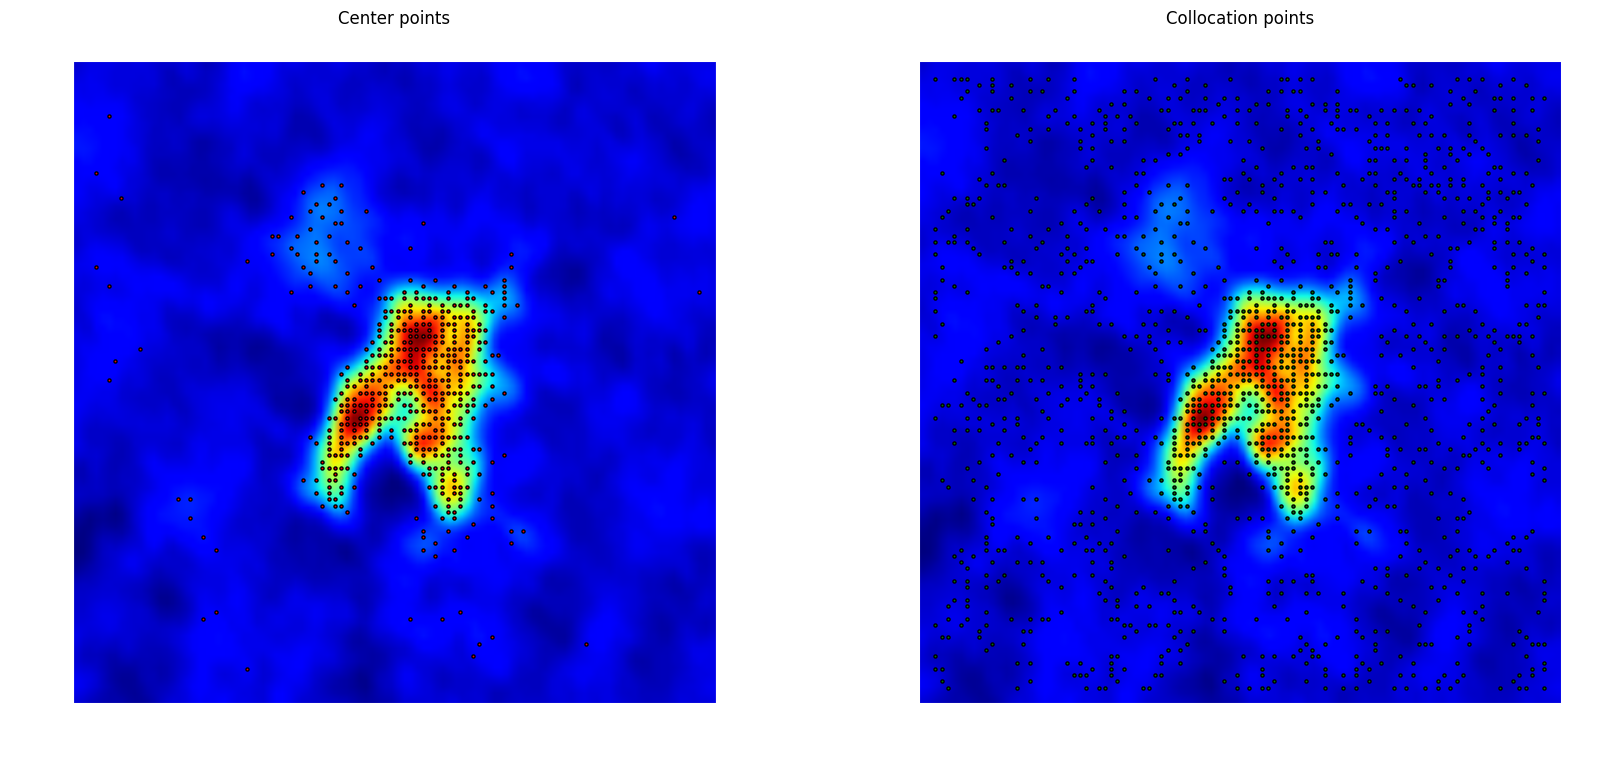

In [9]:
points_plot(data, center_points=center_points, collocation_points=collocation_points)

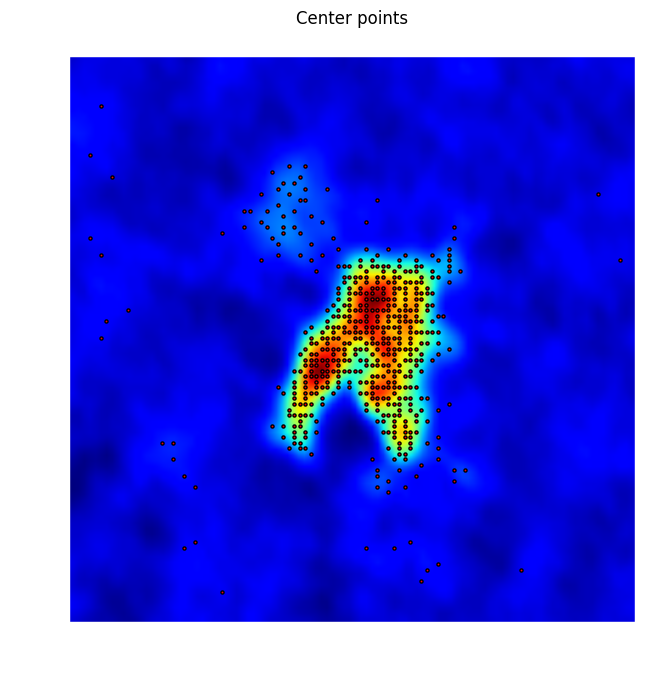

In [10]:
points_plot(data, center_points=center_points)

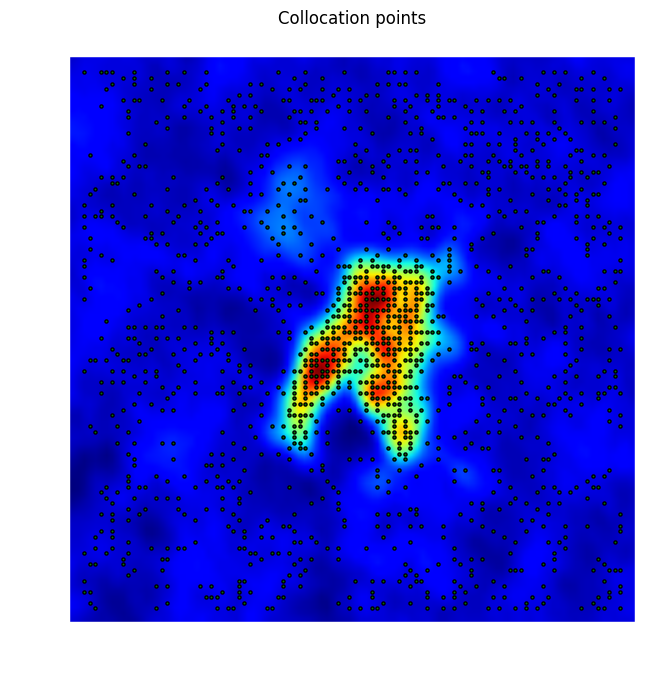

In [11]:
points_plot(data, collocation_points=collocation_points)

In [12]:
points_plot(data, boundary_points=boundary_points)

In [13]:
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

## Initial Conditions

In [14]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

## Visualizing the initial solution

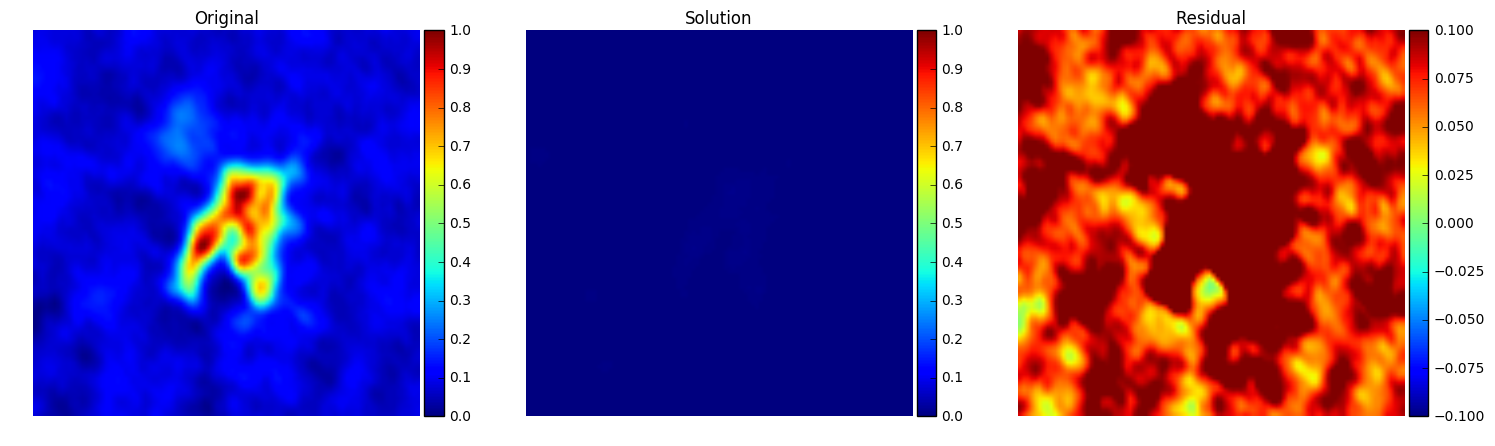

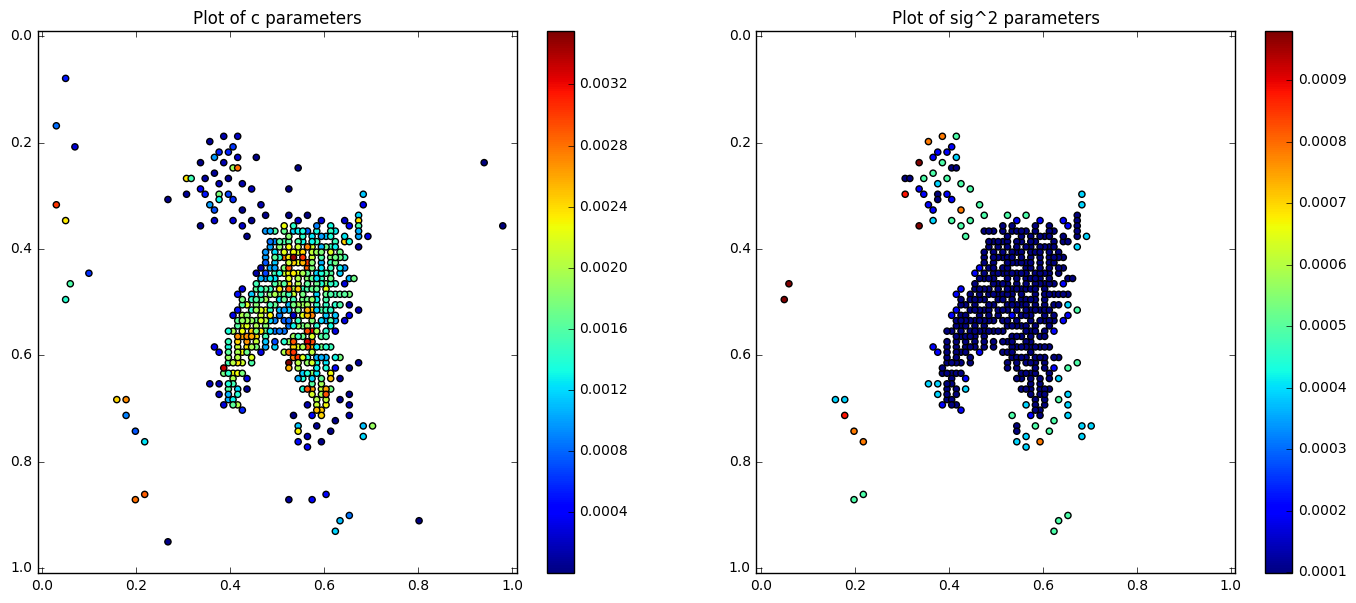

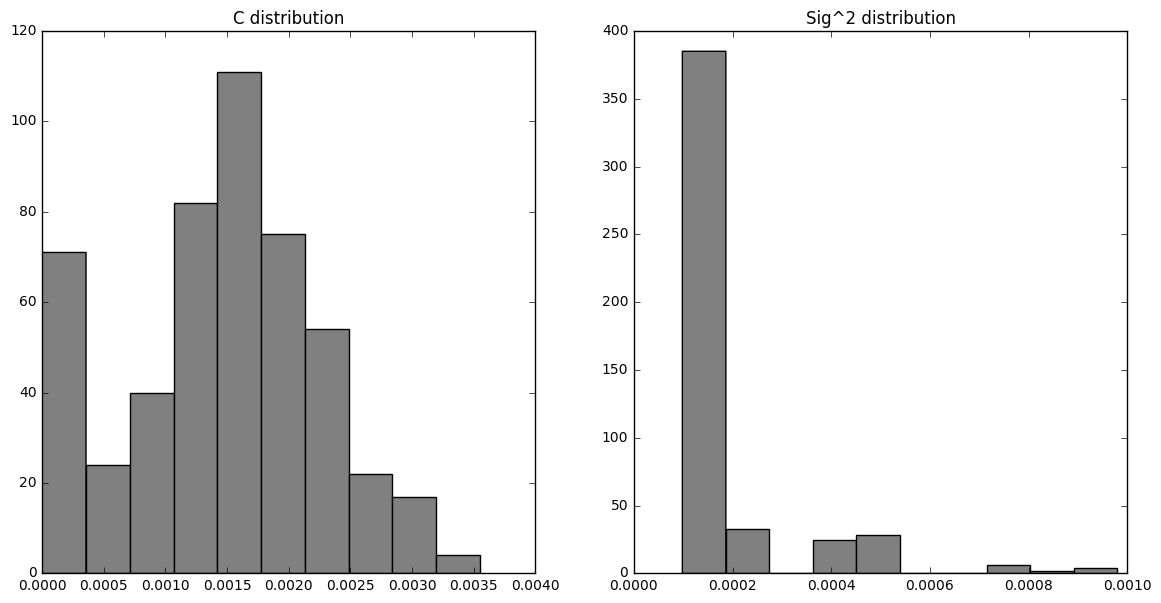

In [15]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=0., compact_supp=False)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

# Experiments 1: With  `base_level=0`
The following instances are tests with different settings combinations for: square_c and support

In [16]:
"""
ELFunc instantiations
"""

elf01 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf02 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=False, compact_supp=False)

### C-squared and no compact support

In [ ]:
el_solver(elf01, method='exact', step_iter=1000, max_iter=50000)

### C-not squared and no compact support


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.216119804485
variation on sig = 1.09115374318

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.291029600469
variation on sig = 2.79412544826

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.1516

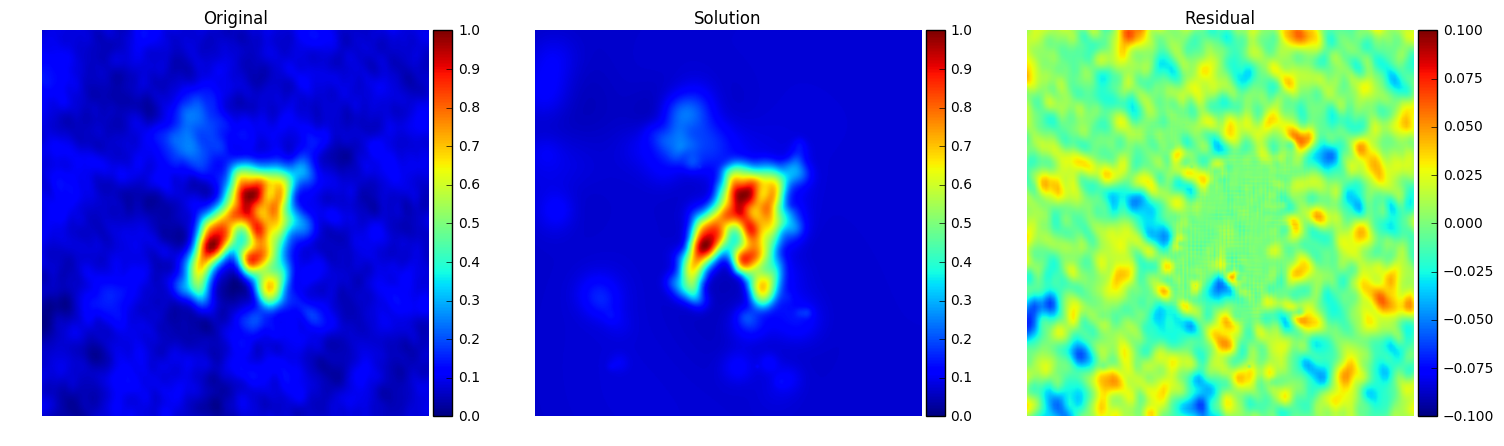

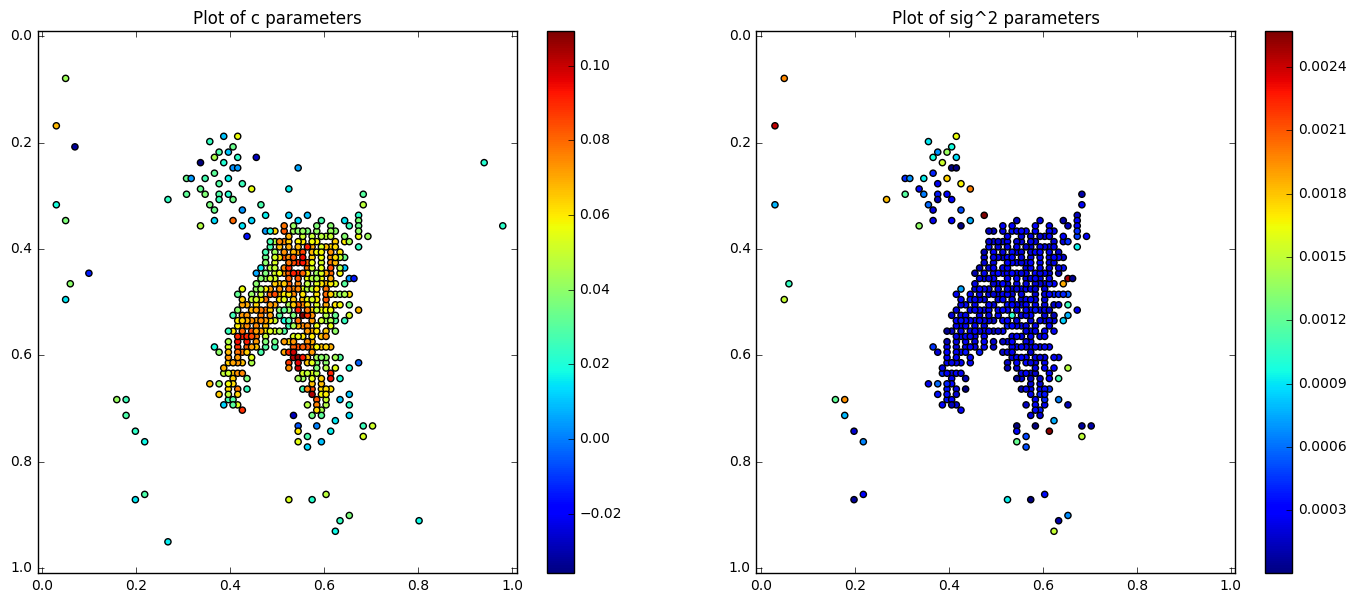

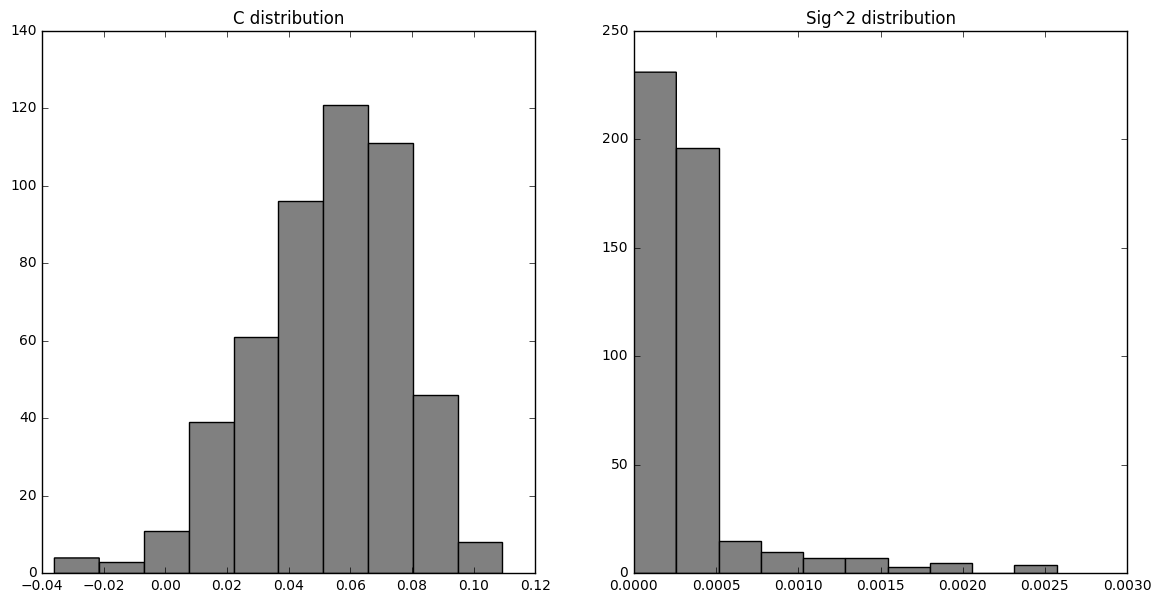

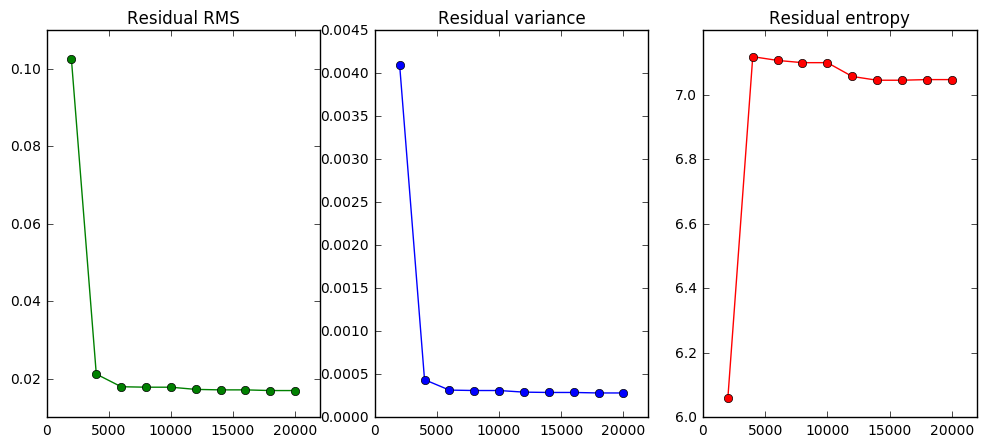

In [18]:
el_solver(elf02, method='exact', step_iter=1000, max_iter=50000)

# Adding the smoothing effect

In [19]:
"""
ELFunc instantiations
"""

elf03 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.001, lamb2=1., 
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


elf04 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., b=0.0001, lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.420292850953
variation on sig = 0.126101702095

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.00128185602808
variation on sig = 9.40567614955e-05

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2012

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c =

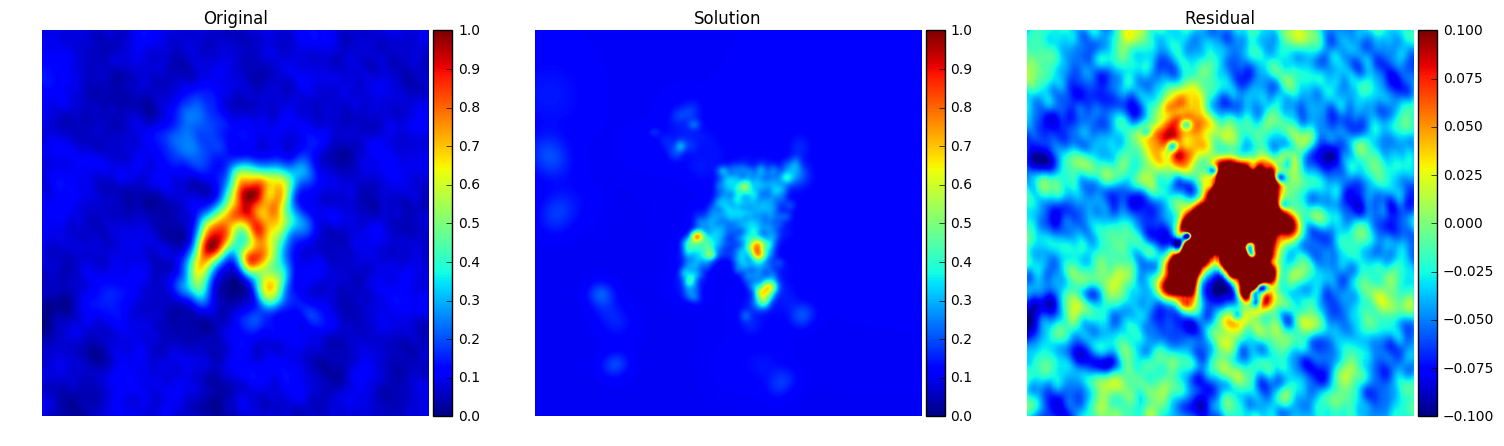

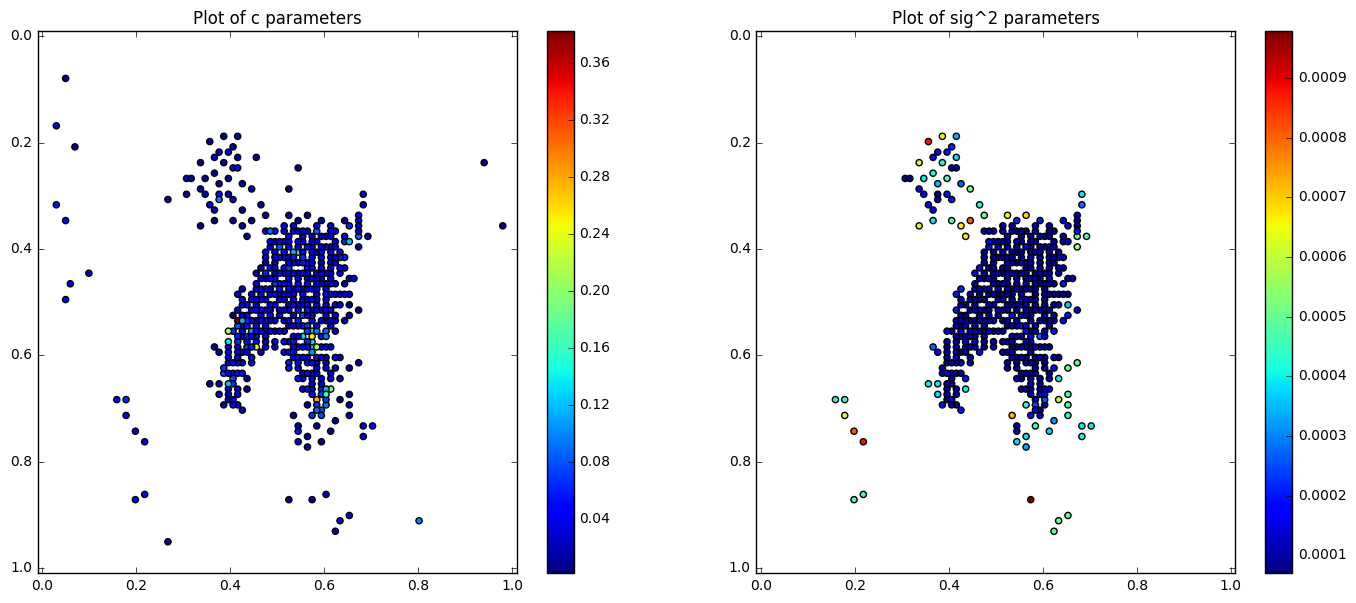

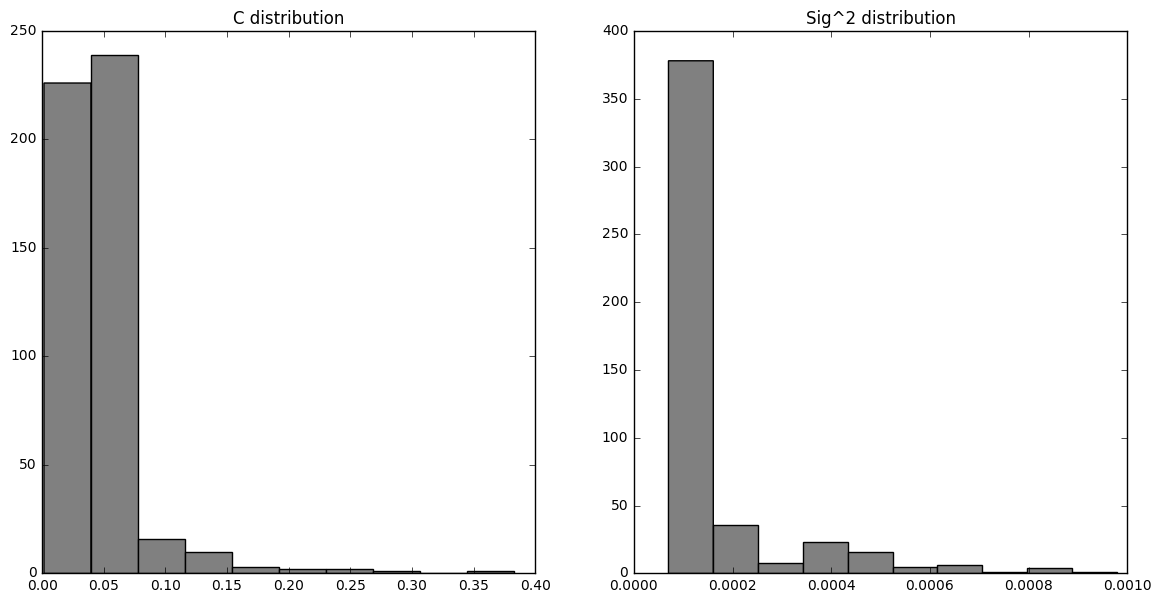

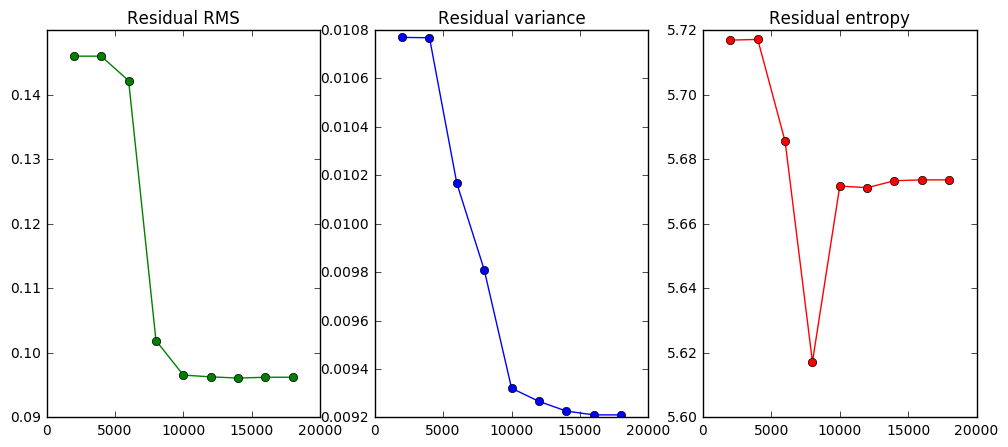

In [20]:
el_solver(elf03, method='exact', step_iter=1000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 1.00787953407
variation on sig = 3.31300469761

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 1.10749635424
variation on sig = 2.62822686169

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.642596

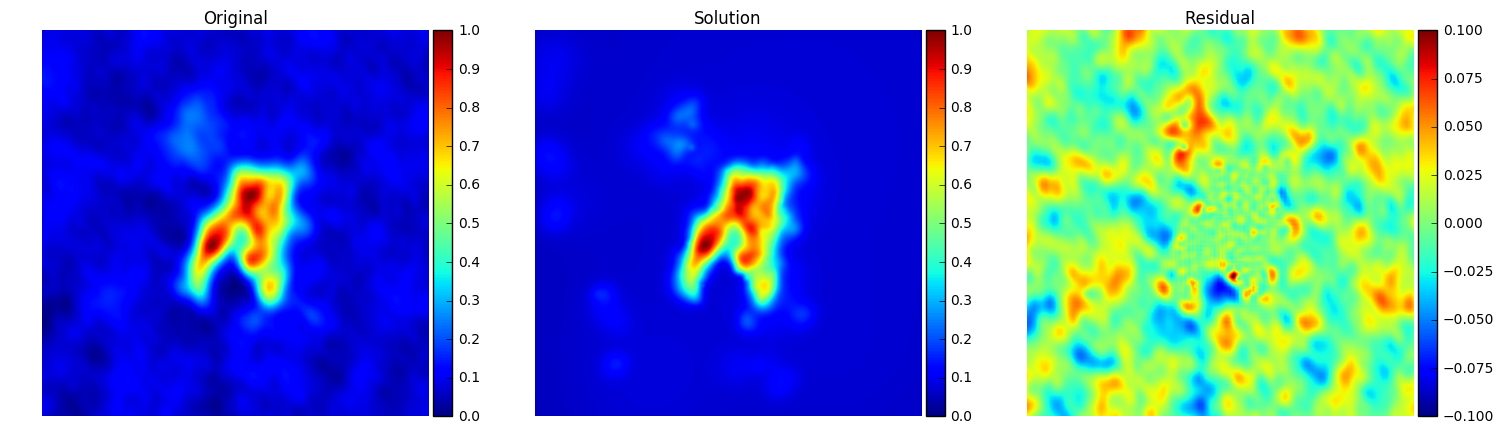

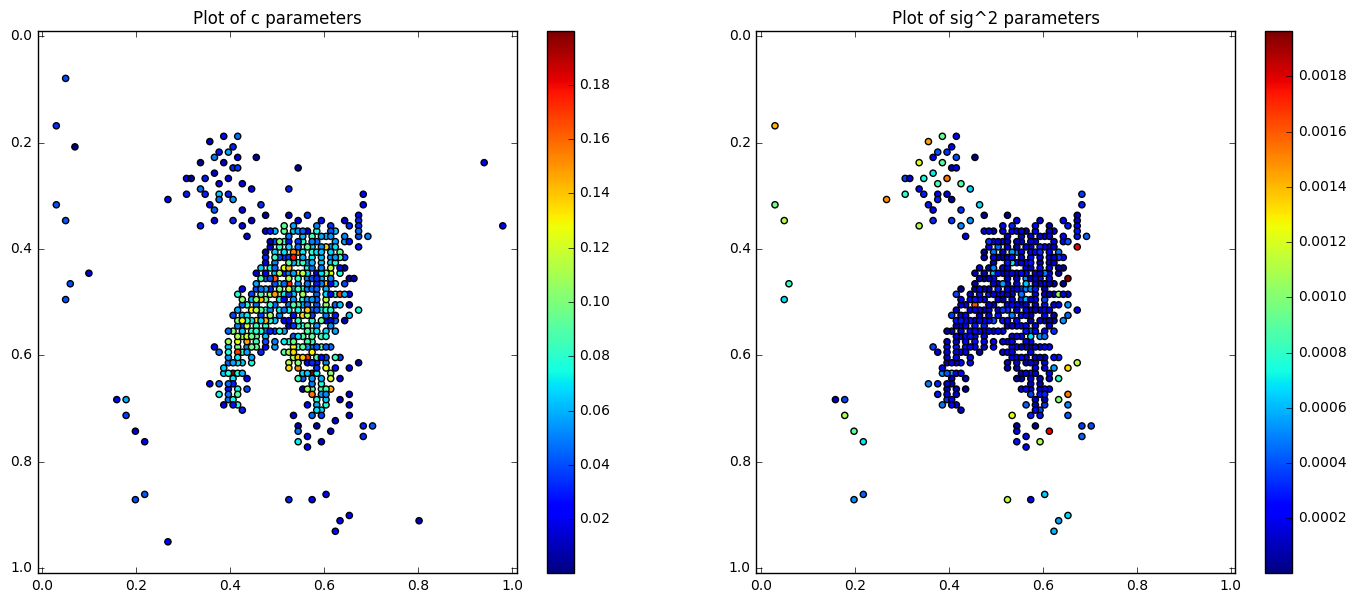

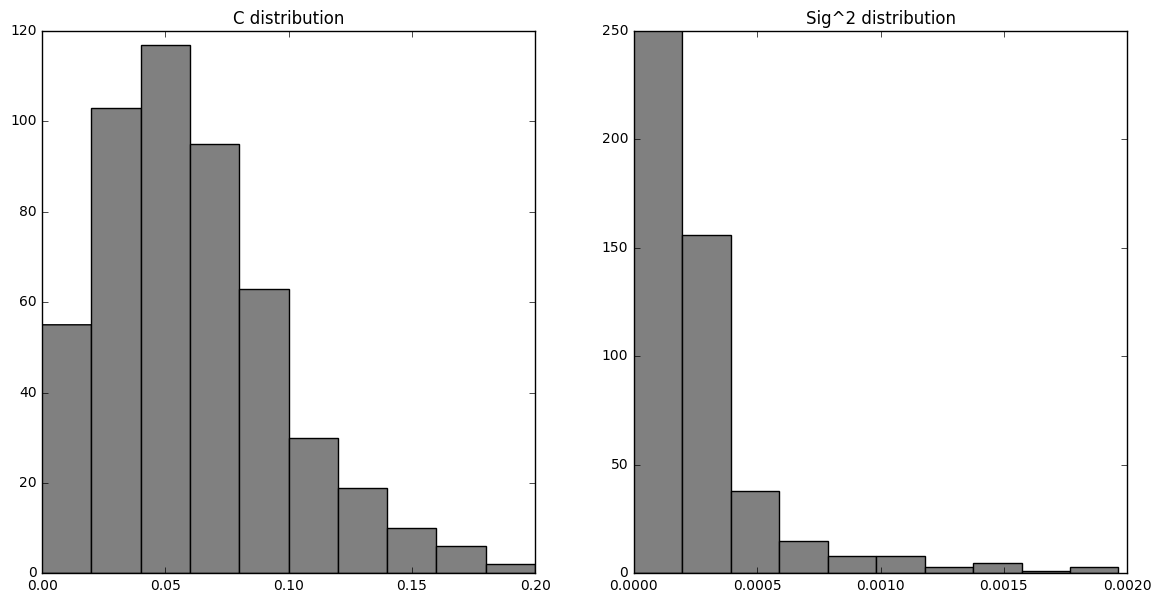

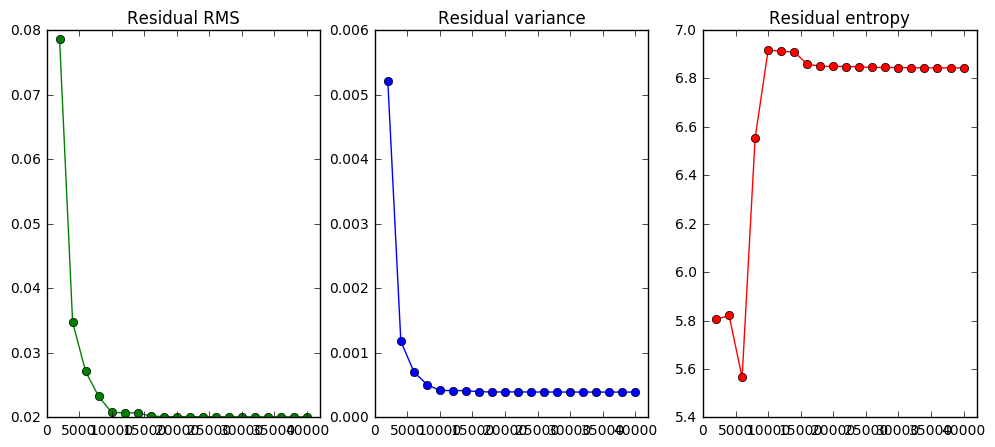

In [21]:
el_solver(elf04, method='exact', step_iter=1000, max_iter=50000)

## Greater penalty on flux addition term

In [22]:
"""
ELFunc instantiations
"""

elf05 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=1., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf06 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)

elf07 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=5., lamb1=5., b=0., lamb2=1.,
               d1psi1=d1psi, d1psi2=d1psi, d2psi2=d2psi, base_level=0., square_c=True, compact_supp=False)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.385813891962
variation on sig = 3.48548509277

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.2284

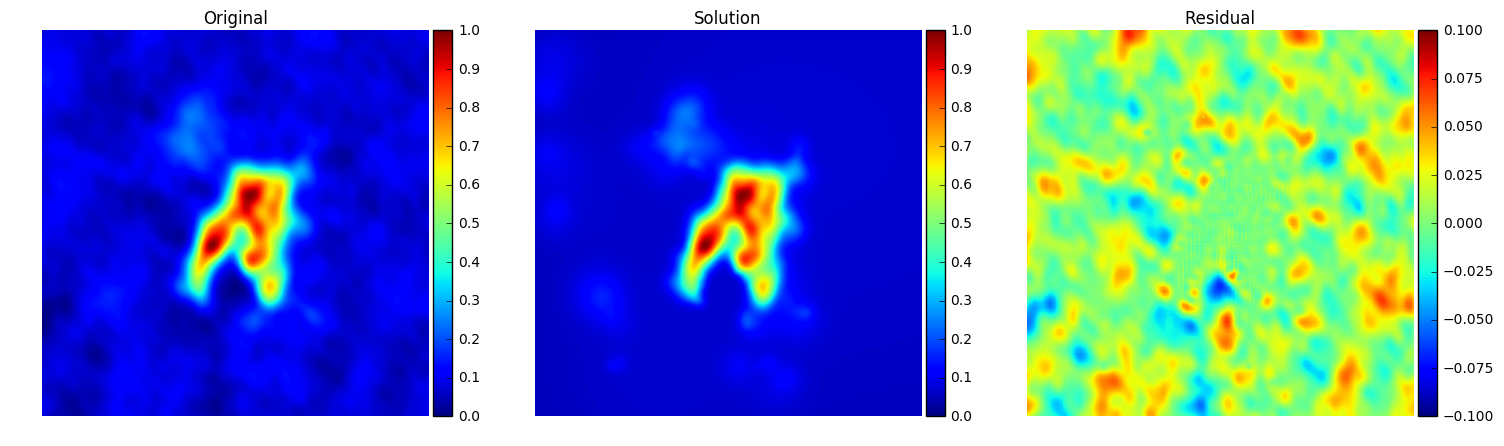

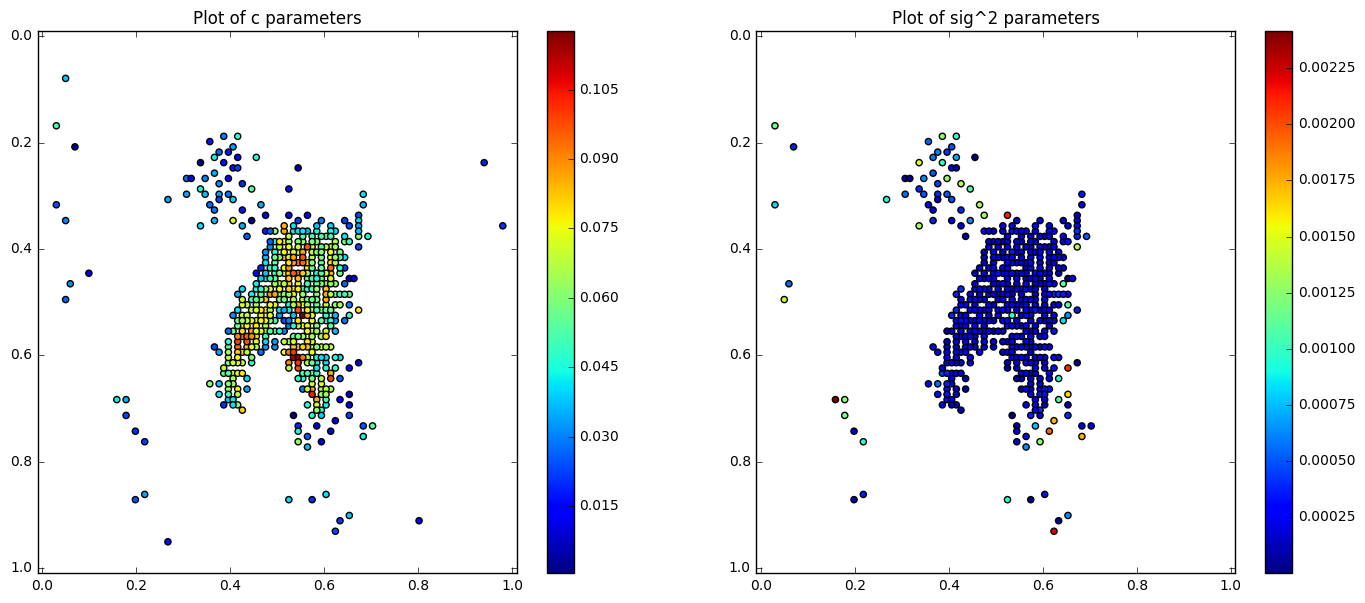

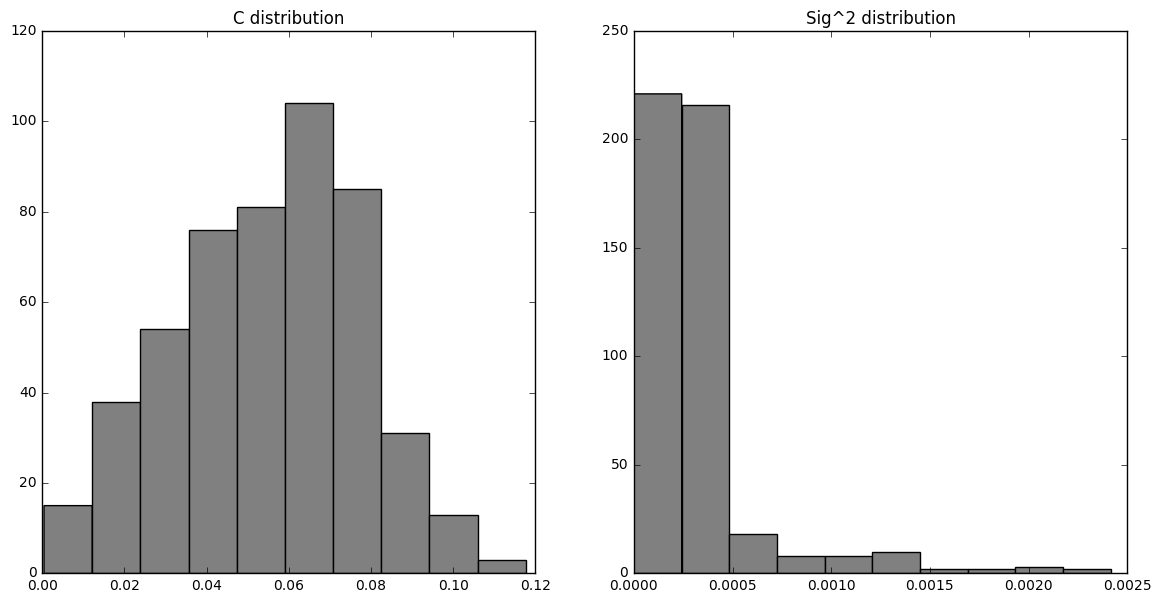

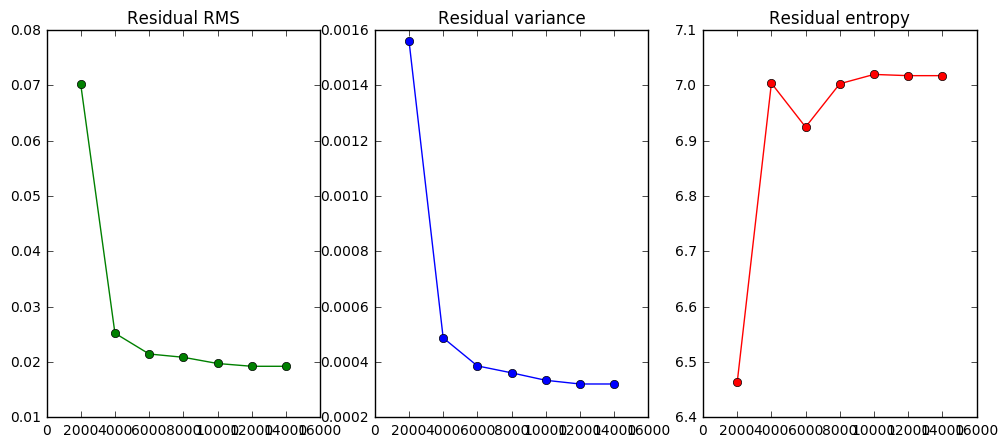

In [23]:
el_solver(elf05, method='exact', step_iter=1000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.14614071095
variation on sig = 0.152431806839

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2007

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.0313

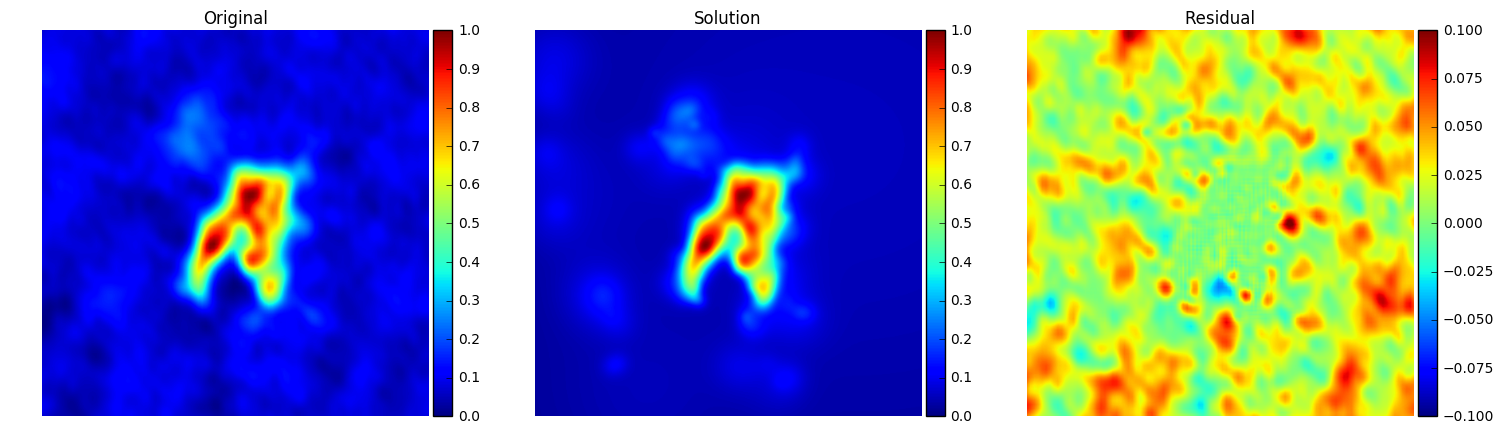

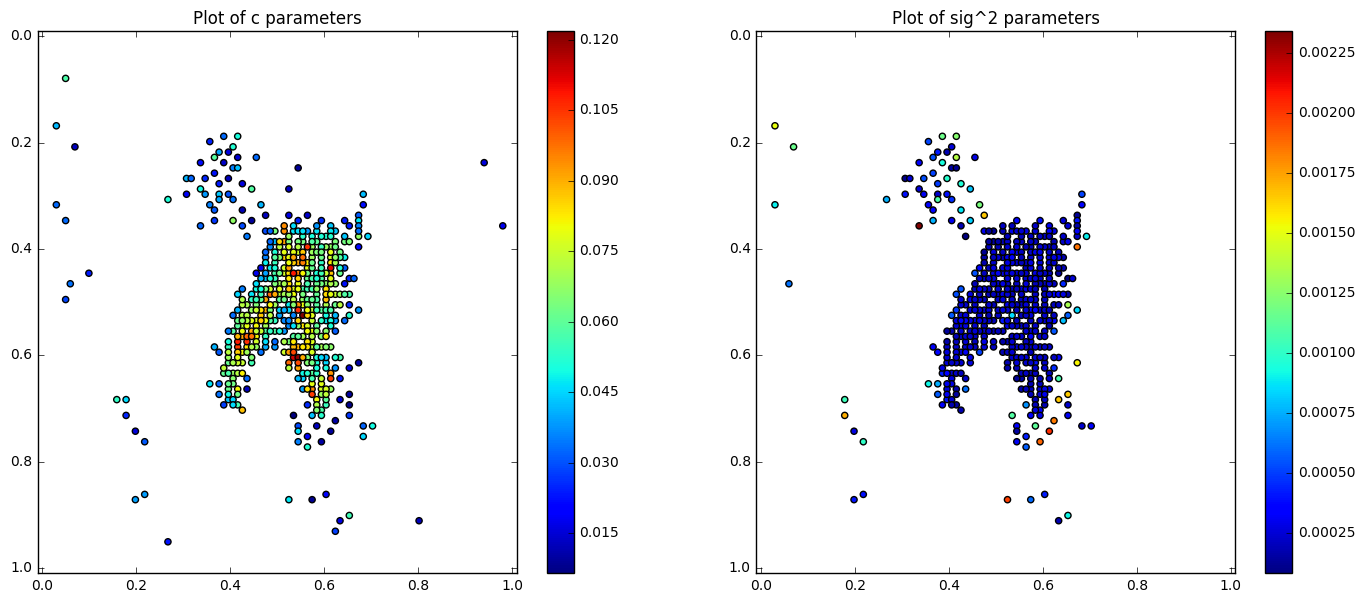

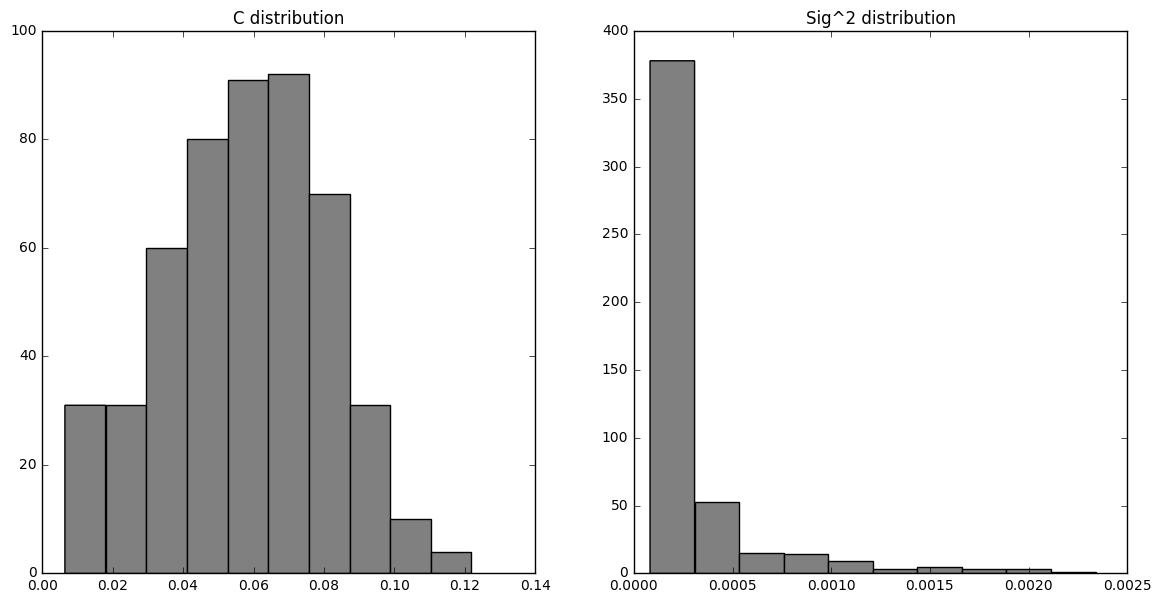

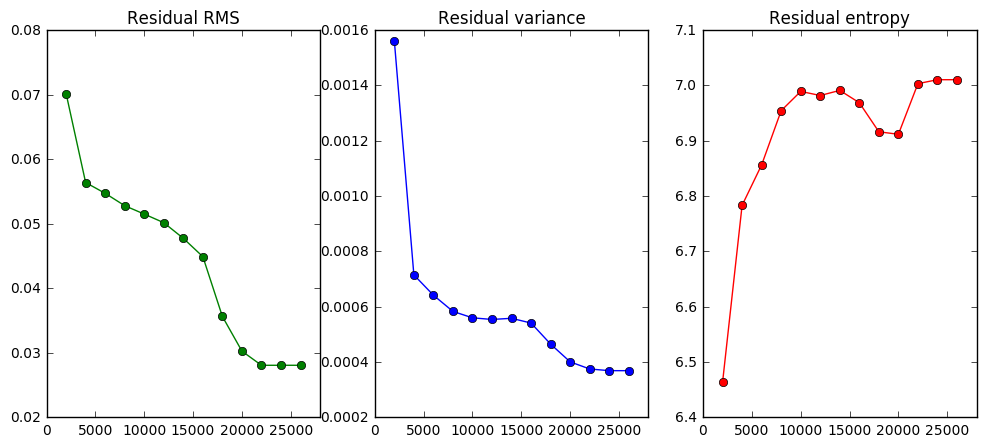

In [24]:
el_solver(elf06, method='exact', step_iter=1000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.769658023914
variation on sig = 1.42310203102

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2006

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 0.0611791908479
variation on sig = 0.0119369143042

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2008

##########################################################################################
Results after 6000 iterations
##########################################################################################
Variation on c = 0.0

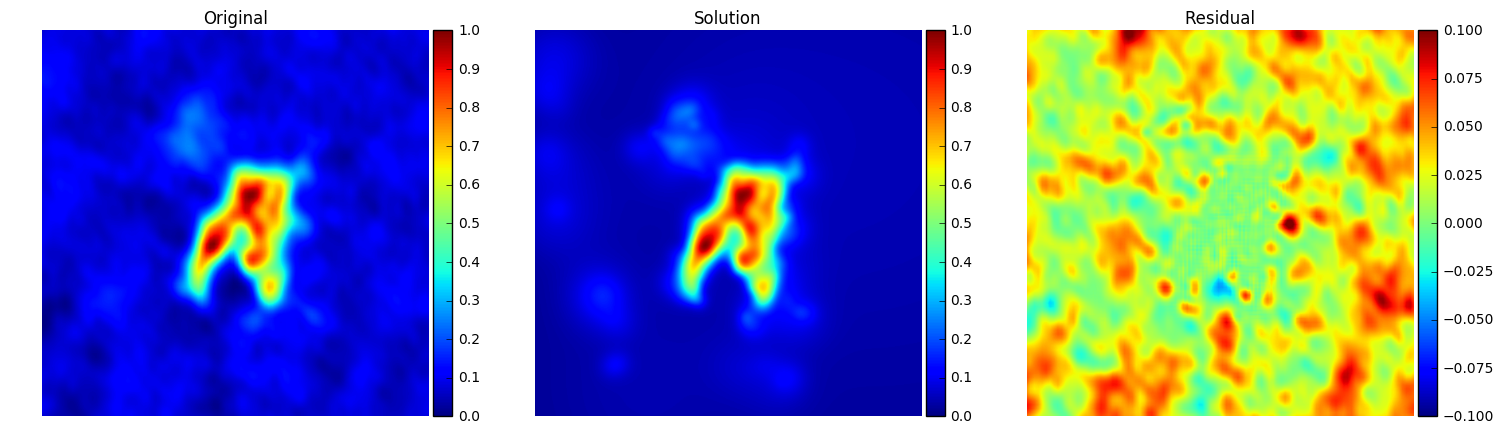

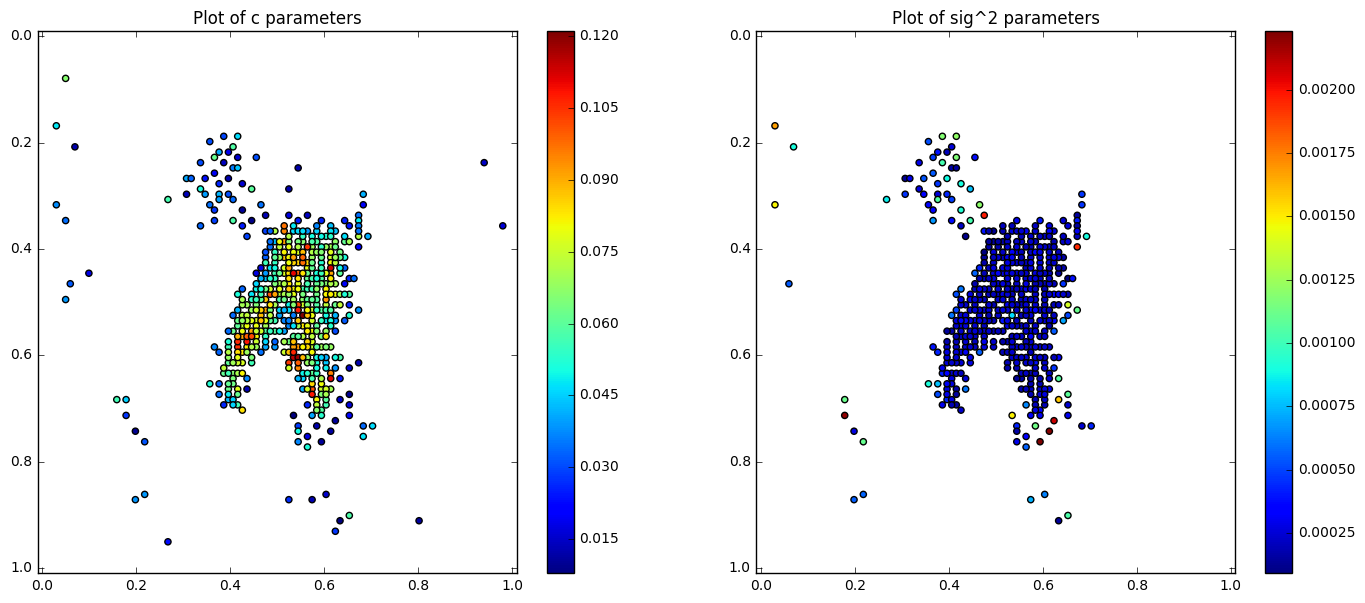

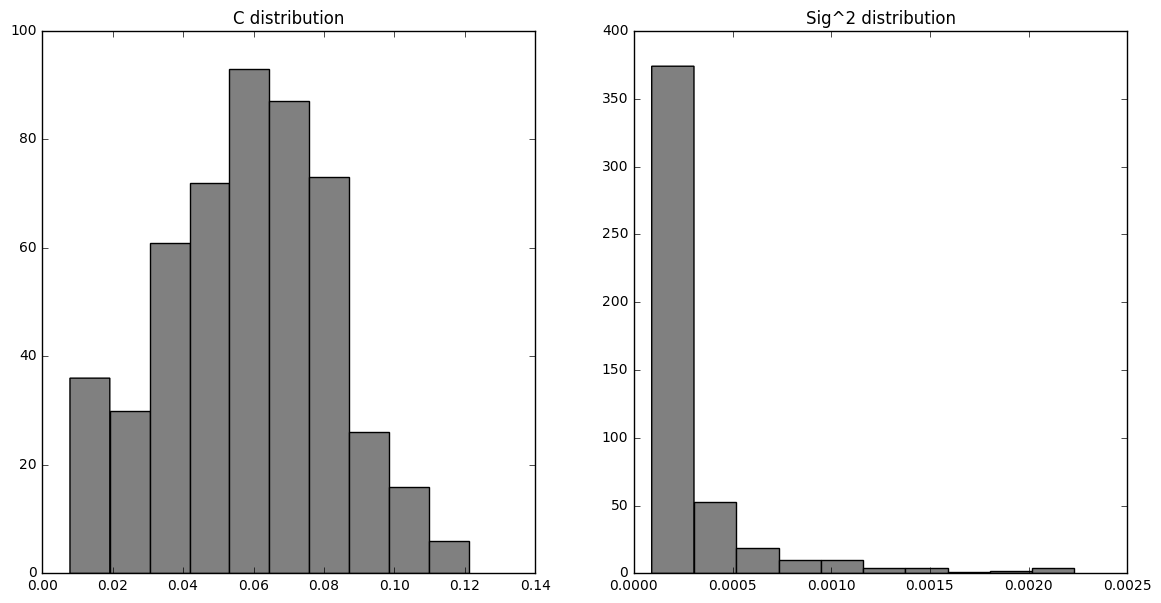

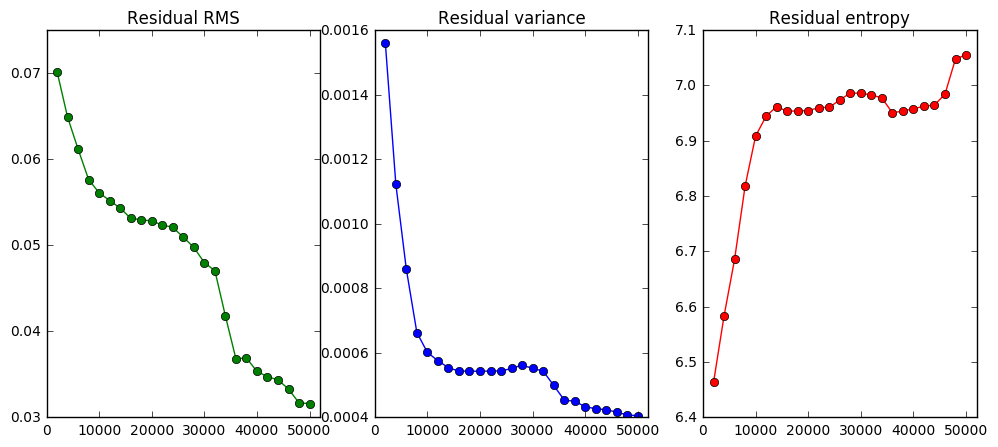

In [25]:
el_solver(elf07, method='exact', step_iter=1000, max_iter=50000)

# Experiments 2: With  `base_level=RMS`

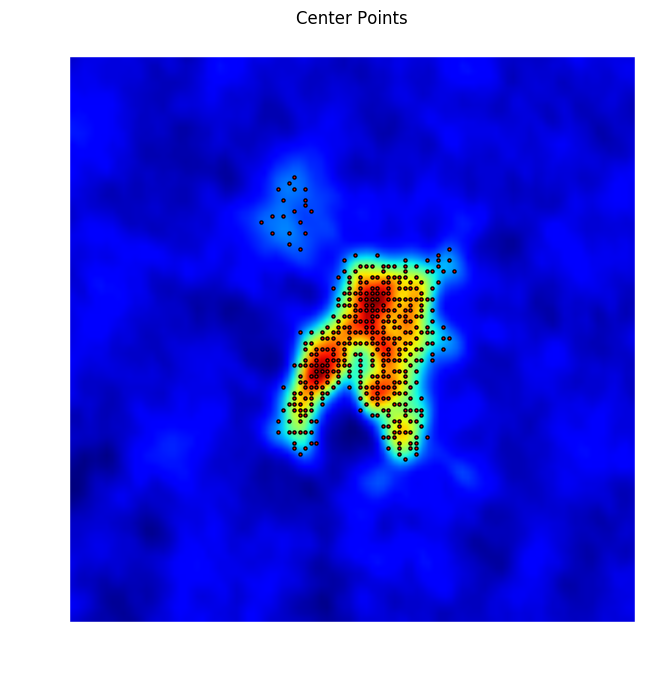

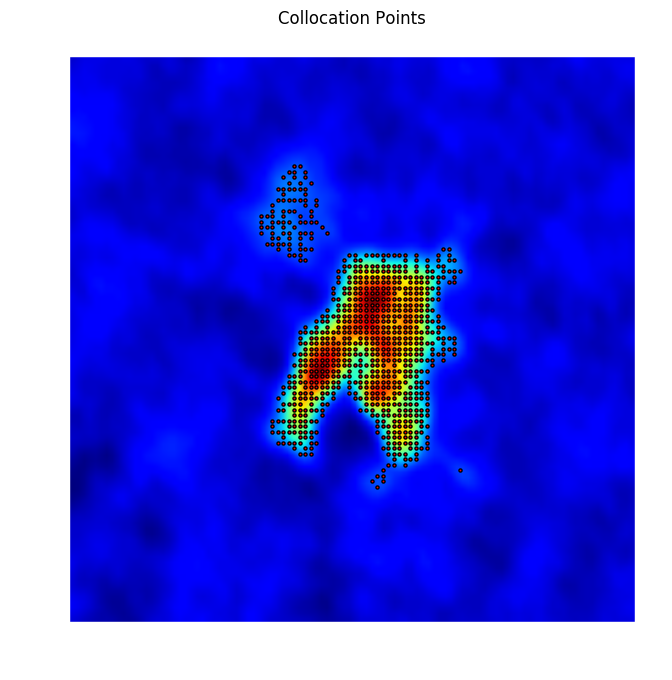

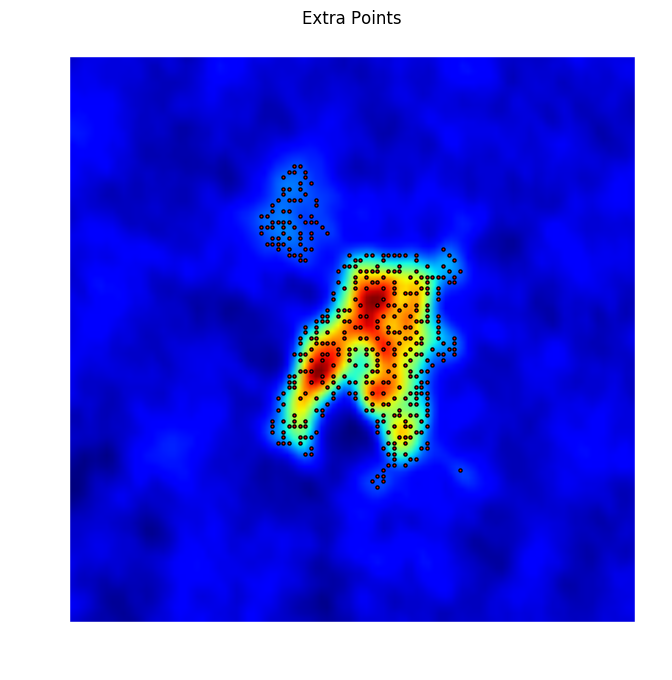

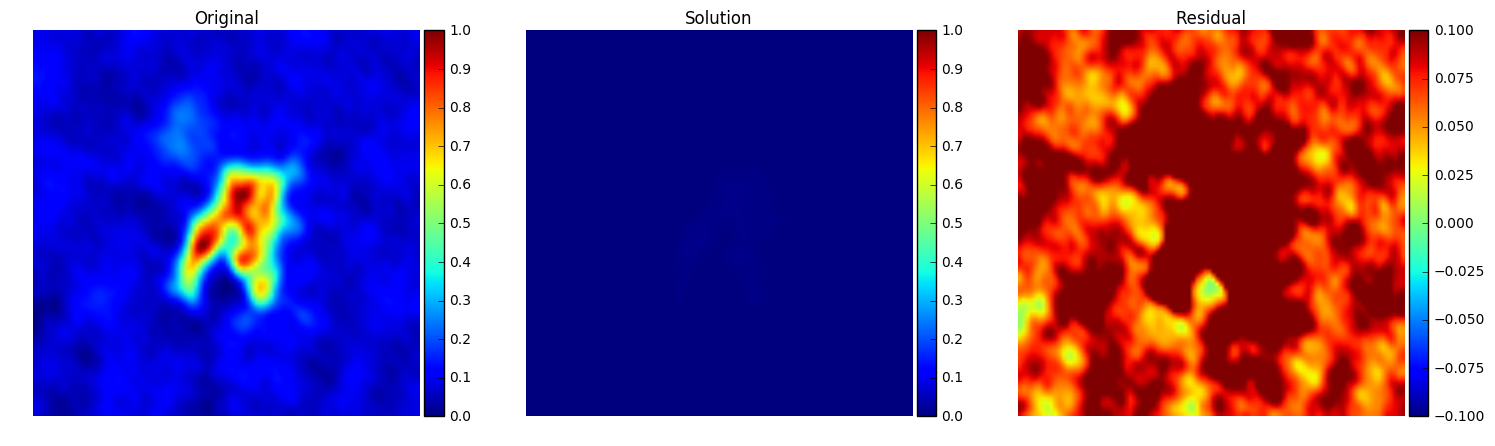

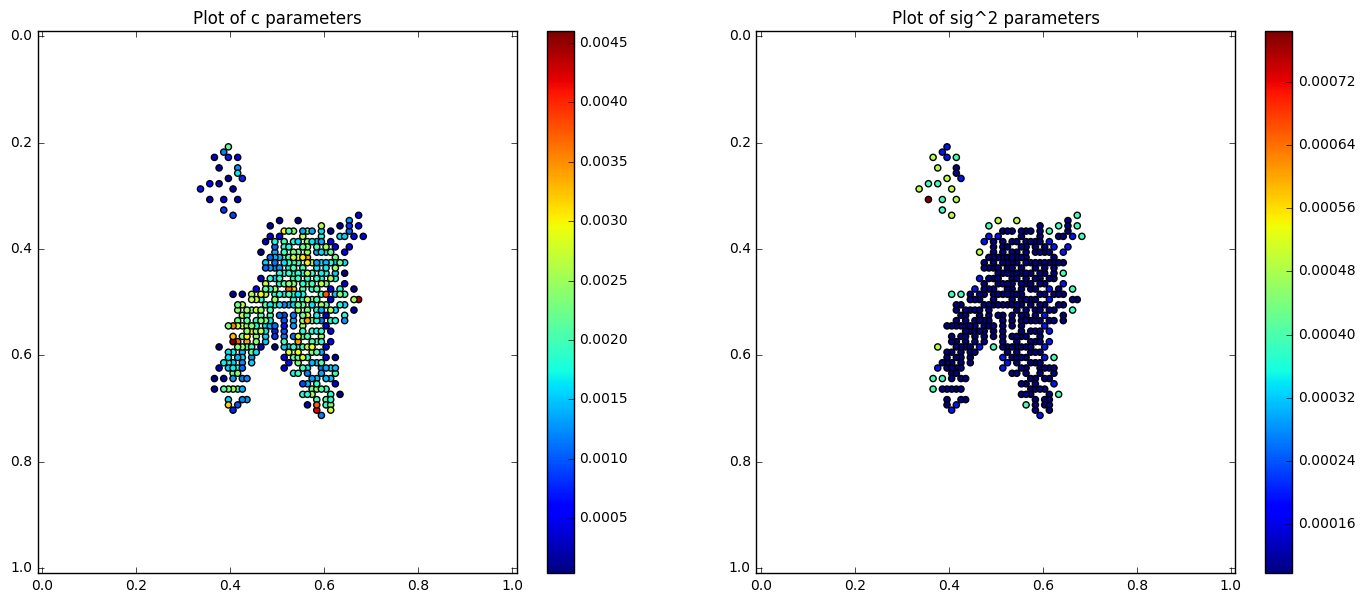

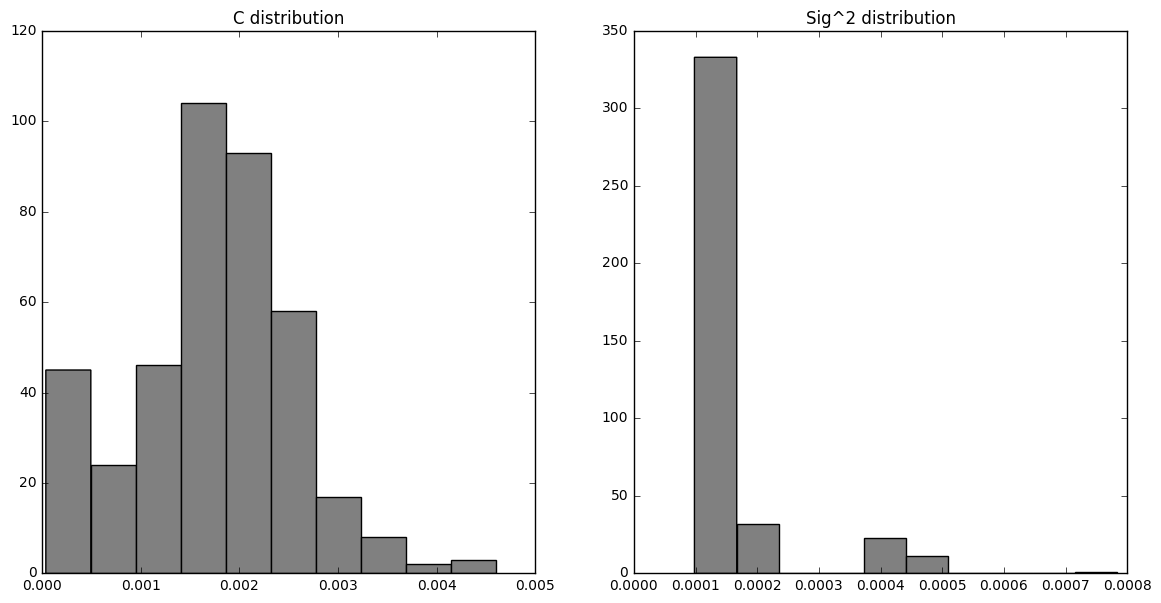

In [5]:
Nc = 400
Nb = 0
base_level = estimate_rms(data)

centers = random_centers_generation(data, 2*Nc, cut_value_leq=base_level)
boundary_points = boundary_generation(Nb)
center_points = centers[0:Nc]
collocation_points = centers

# right formating
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, center_points=centers[Nc:], title="Extra Points")

# initial conditions
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, method='min_dist')

# visualizing the initial solution
solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=0., compact_supp=False)
params_plot(c0, sig0, xc, yc, square_c=True)
params_distribution_plot(c0, sig0, square_c=True)

In [6]:
"""
ELFunc instantiations
"""

elf08 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True)

elf09 = ELFunc(dfunc, data.shape, xe, ye, xc, yc, xb, yb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, d1psi2=d1psi,
              d2psi2=d2psi, base_level=0., square_c=True, compact_supp=True)


##########################################################################################
Results after 1000 iterations
##########################################################################################
Variation on c = 0.759564972691
variation on sig = 0.133708205977

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1606

##########################################################################################
Results after 2000 iterations
##########################################################################################
Variation on c = 0.478312870635
variation on sig = 0.0744763370027

success: False

status: 5

message: Number of calls to function has reached maxfev = 1000.

nfev: 1606

##########################################################################################
Results after 3000 iterations
##########################################################################################
Variation on c = 0.2

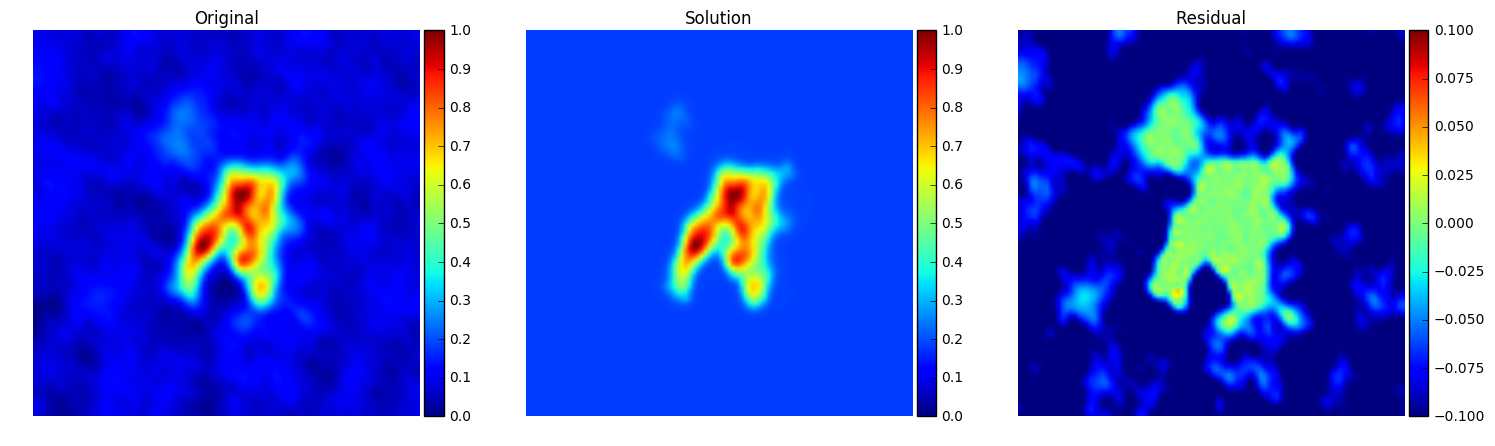

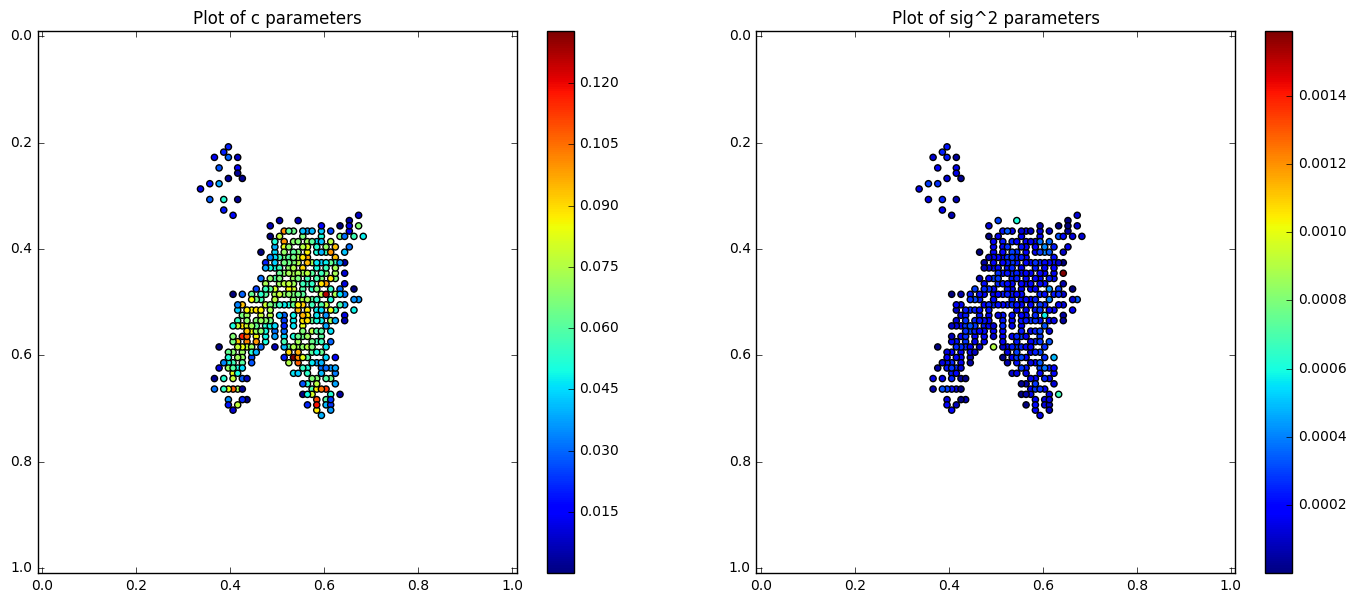

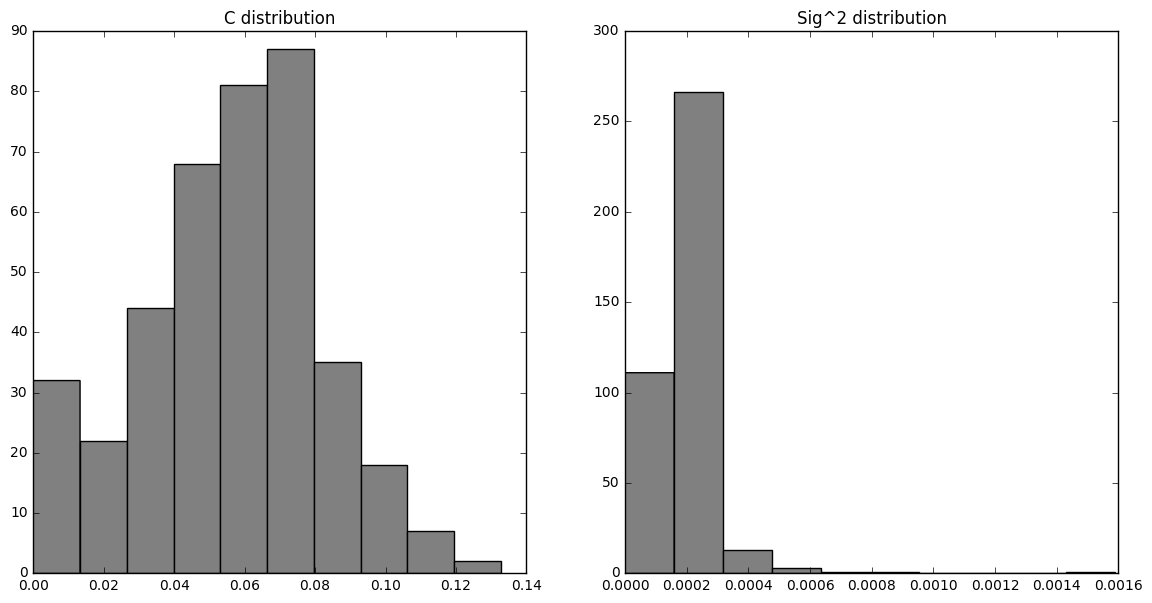

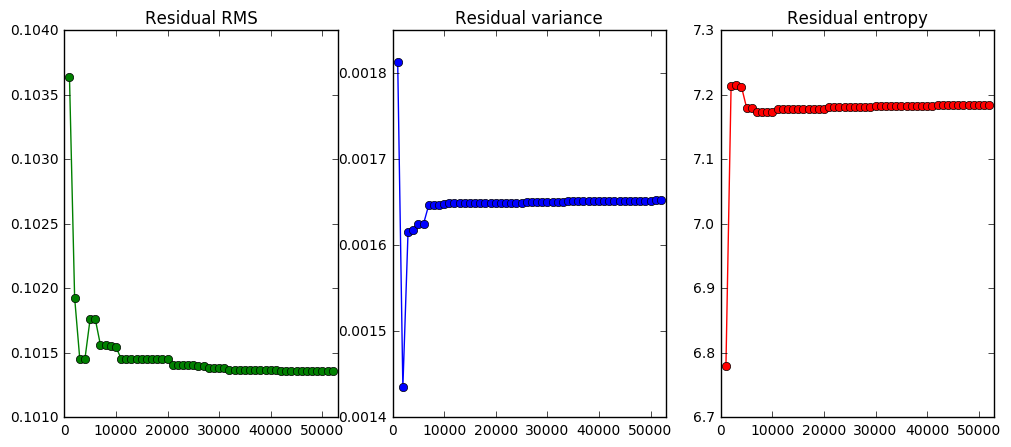

In [7]:
el_solver(elf08, method='exact', step_iter=1000, max_iter=100000)

In [ ]:
el_solver(elf09, method='exact', step_iter=1000, max_iter=100000)

## Visualizing the level sets

In [27]:
def level_set_plot(data, level):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    _data = np.zeros(data.shape)
    mask = data > level
    _data[mask] = data[mask]
    im = ax.imshow(_data)
    plt.title('Center points plot')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)
    plt.show()

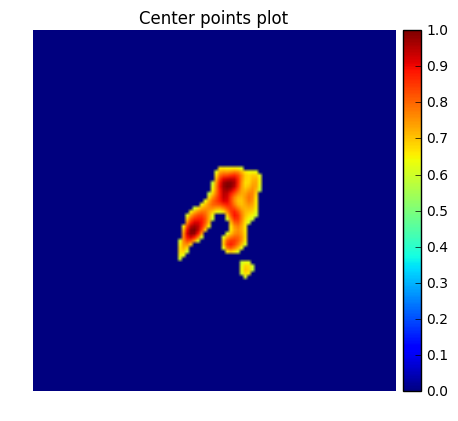

<function __main__.level_set_plot>

In [28]:
interact(level_set_plot, data=fixed(data), level=(base_level, 1.))

## Gaussian reduction through `KL-divergence`
### _A Kullback-Leibler Approach to Gaussian Mixture Reduction_

In [ ]:
@numba.jit('float64[:] (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def merge(c1, mu1, sig1, c2, mu2, sig2):
    c_m = c1+c2
    mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
    sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*np.outer(mu1-mu2, mu1-mu2)
    return (c_m, mu_m, sig_m) 


@numba.jit('float64 (float64, float64[:], float64[:,:], float64, float64[:], float64[:,:])', nopython=True)
def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    pass

In [8]:
def merge(c1, mu1, sig1, c2, mu2, sig2):
    c_m = c1+c2
    mu_m = (c1/c_m)*mu1 + (c2/c_m)*mu2
    sig_m = (c1/c_m)*sig1 + (c2/c_m)*sig2 + (c1/c_m)*(c2/c_m)*np.outer(mu1-mu2, mu1-mu2)
    return (c_m, mu_m, sig_m)

def KL_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # KL divergence upper bound as proposed in: A Kullback-Leibler Approach to Gaussian Mixture Reduction
    return 0.5*((c1+c2)*np.log(np.linalg.det(sig_m)) - c1*np.log(np.linalg.det(sig1)) - c2*np.log(np.linalg.det(sig2)))

In [9]:
def gaussian_reduction(c, mu, sig, n_comp, metric=KL_dissimilarity):
    c = c.tolist(); mu = map(np.array, mu.tolist()); sig = [(s**2)*np.identity(2) for s in sig]
    # indexes of the actual gaussian components
    components = [[i] for i in range(len(c))]
    components_dict = {len(components) : copy.deepcopy(components)}
    # main loop
    while len(components)>n_comp:
        m = len(c)
        diss_min = np.inf
        i_min = -1; j_min = -1
        for i in range(m):
            for j in range(m):
                if i==j: continue
                diss = metric(c[i], mu[i], sig[i], c[j], mu[j], sig[j])
                if diss < diss_min: i_min = i; j_min = j; diss_min = diss
        # compute the moment preserving  merged gaussian
        c_m, mu_m, sig_m = merge(c[i_min], mu[i_min], sig[i_min], c[j_min], mu[j_min], sig[j_min])
        # updating structures
        print('Merged components {0} and {1} with {2} dissimilarity'.format(i_min, j_min, diss_min))
        del c[max(i_min, j_min)]; del c[min(i_min, j_min)]; c.append(c_m)
        del mu[max(i_min, j_min)]; del mu[min(i_min, j_min)]; mu.append(mu_m)
        del sig[max(i_min, j_min)]; del sig[min(i_min, j_min)]; sig.append(sig_m)
        new_component = components.pop(max(i_min,j_min)) + components.pop(min(i_min,j_min))
        new_component.sort()
        components.append(new_component)
        components_dict[m-1] = copy.deepcopy(components)
    return components_dict

In [10]:
# extracting parameters
if elf08.square_c: c = elf08.c**2
else: c = elf08.c
    
mu = np.vstack([elf08.xc, elf08.yc]).T
sig = elf08.sig

In [ ]:
components_dict08 = gaussian_reduction(c, mu, sig, n_comp=5)

Merged components 164 and 191 with 3.84811851519e-11 dissimilarity
Merged components 347 and 76 with 6.28672218679e-09 dissimilarity
Merged components 349 and 299 with 8.95257047135e-07 dissimilarity
Merged components 250 and 238 with 6.22159016028e-06 dissimilarity
Merged components 201 and 359 with 0.000414908519724 dissimilarity
Merged components 333 and 376 with 0.000797294775016 dissimilarity
Merged components 167 and 376 with 0.00185590206461 dissimilarity
Merged components 247 and 327 with 0.00227046094105 dissimilarity
Merged components 115 and 330 with 0.00247304287664 dissimilarity
Merged components 358 and 286 with 0.0029934075875 dissimilarity
Merged components 358 and 211 with 0.00307471258649 dissimilarity
Merged components 356 and 324 with 0.00326184367747 dissimilarity
Merged components 206 and 317 with 0.00333487536345 dissimilarity
Merged components 269 and 339 with 0.00351836168777 dissimilarity
Merged components 53 and 186 with 0.00354176493829 dissimilarity
Merged 

In [25]:
# extracting parameters
if elf09.square_c: c = elf09.c**2
else: c = elf09.c
    
mu = np.vstack([elf09.xc, elf09.yc]).T
sig = elf09.sig

In [42]:
components_dict09 = gaussian_reduction(c, mu, sig, n_comp=5)

Merged components 165 and 13 with 8.21509527071e-11 dissimilarity
Merged components 357 and 191 with 7.88333841645e-07 dissimilarity
Merged components 177 and 310 with 1.23930304943e-05 dissimilarity
Merged components 369 and 396 with 9.95443938911e-05 dissimilarity
Merged components 278 and 356 with 0.000228126871243 dissimilarity
Merged components 326 and 345 with 0.000359646162873 dissimilarity
Merged components 376 and 288 with 0.000362307403776 dissimilarity
Merged components 303 and 381 with 0.00071377822646 dissimilarity
Merged components 171 and 390 with 0.00100295029402 dissimilarity
Merged components 164 and 335 with 0.00106197137659 dissimilarity
Merged components 227 and 312 with 0.00162204913256 dissimilarity
Merged components 115 and 331 with 0.00170663696261 dissimilarity
Merged components 329 and 297 with 0.00173856319328 dissimilarity
Merged components 288 and 243 with 0.00177901099649 dissimilarity
Merged components 75 and 228 with 0.00190729339542 dissimilarity


KeyboardInterrupt: 

In [50]:
np.arange(1.01*base_level, 0.95, 5)

array([ 0.18883207])

In [ ]:
1.01*base_level

In [61]:
def components_plot(elf, data, components_dict, n_comp, dims, resolution=1, n_levels=5):
    xc = elf.xc; yc = elf.yc; c = elf.c; sig = elf.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elf.square_c: c = c**2
    if elf.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(10,10))
    plt.title('{0} components solution'.format(n_comp))
    plt.axis('off')
    ax = plt.subplot(1,1,1)
    ax.imshow(data, cmap=plt.cm.gray)
    color = plt.cm.rainbow(np.linspace(0.,1.,n_comp))
    levels = np.linspace(1.05*base_level, 0.95, n_levels)
    
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elf.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        ax.contour(_u, levels=levels, colors=[color[i]])
        #plt.subplot(n_comp,1, i+1)
        #ax = plt.gca()
        #im = ax.imshow(_u, vmin=0., vmax=1.)
        #plt.axis('off')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #plt.colorbar(im, cax=cax)
    plt.show()
    
def components_plot2(elf, components_dict, n_comp, dims, resolution=2):
    xc = elf.xc; yc = elf.yc; c = elf.c; sig = elf.sig
    _xe = np.linspace(0., 1., resolution*dims[0])[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1])[1:-1]
    len_xe = len(_xe); len_ye = len(_ye)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    """ 
    Computing distance matrices
    """
    #distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    """
    Computing the Phi matrix
    """
    if elf.square_c: c = c**2
    if elf.compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)    
    
    plt.figure(figsize=(12,12))
    plt.title('{0} components solution'.format(n_comp))
    j = 1
    
    for i,indexes in enumerate(components_dict[n_comp]):
        _phi_m = phi_m.T[indexes].T
        _c = c[indexes]
        _u = np.dot(_phi_m, _c) + elf.base_level
        _u = _u.reshape(len_xe, len_ye)
        
        __u = _u[_u > base_level]
        
        plt.subplot(n_comp,1, j)
        j+=1
        
        ax = plt.gca()
        __u = np.log10(_u)
        im = ax.imshow(_u, vmin=0., vmax=1.)
        #im = ax.imshow((__u + __u.min())/(__u.max()-__u.min()), vmin=0., vmax=1.)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        #plt.subplot(2*n_comp,1,j)
        #plt.hist(_u.ravel(), bins=400, log=True)
        #j+=1
    plt.show()

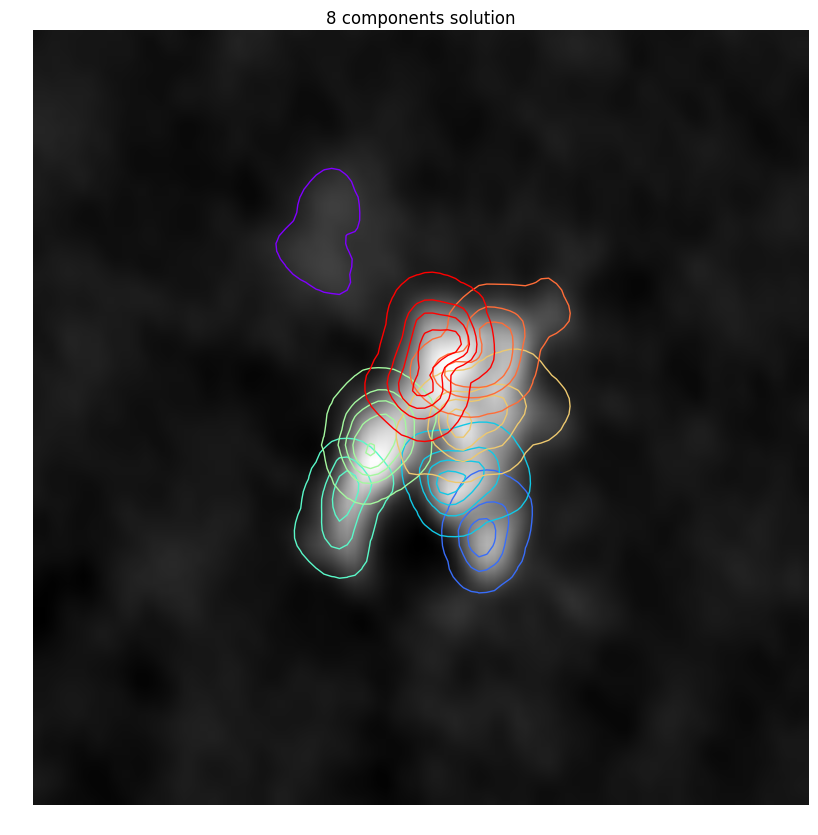

In [62]:
components_plot(elf08, data, components_dict08, 8, dims=(data.shape))

## Gaussian reduction through `ISD` (_Integrated Square Difference_)
### _Cost-Function-Based Gaussian Mixture Reduction for Target Tracking_

In [52]:
def ISD_dissimilarity(c1, mu1, sig1, c2, mu2, sig2):
    # merged moment preserving gaussian
    c_m, mu_m, sig_m = merge(c1, mu1, sig1, c2, mu2, sig2)
    # ISD analytical computation between merged component and the pair of gaussians
    Jhr = c1*c_m * np.exp( -0.5 * np.dot((mu1-mu_m), np.dot(np.linalg.inv(sig1+sig_m), mu1-mu_m)) ) + c2*c_m * np.exp( -0.5 * np.dot((mu2-mu_m), np.dot(np.linalg.inv(sig2+sig_m), mu2-mu_m)) )
    Jrr = c_m**2
    Jhh = c1**2 + c2**2 + 2*c1*c2* np.exp( -0.5 * np.dot((mu1-mu2), np.dot(np.linalg.inv(sig1+sig2), mu1-mu2)) )
    return Jhh - 2*Jhr + Jrr

In [53]:
comp2 = gaussian_reduction(c, mu, sig, n_comp=5, metric=ISD_dissimilarity)

Merged components 52 and 70 with -0.000518399365307 dissimilarity


KeyboardInterrupt: 